### OpenCV Darknet Yolo를 이용하여 이미지Object Detection
* yolo와 tiny-yolo 를 이용하여 Object Detection

#### 입력 이미지로 사용될 이미지 다운로드/보기

In [1]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2022-08-09 10:36:37--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.004s  

2022-08-09 10:36:38 (89.7 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



#### Darknet Yolo사이트에서 coco로 학습된 Inference모델와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성

* https://pjreddie.com/darknet/yolo/ 에 다운로드 URL 있음.
* pretrained 모델은 wget https://pjreddie.com/media/files/yolov3.weights 에서 다운로드
* pretrained 모델을 위한 환경 파일은 https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg 에서 다운로드
* wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg
* readNetFromDarknet(config파일, weight파일)로 config파일 인자가 weight파일 인자보다 먼저 옴. 주의 필요. 

* tiny yolo의 pretrained된 weight파일은 wget https://pjreddie.com/media/files/yolov3-tiny.weights 에서 download 가능. 
* config 파일은 wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg 로 다운로드

In [2]:
### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드하여 /content/pretrained 디렉토리 아래에 저장. 
!mkdir ./pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget -O /content/pretrained/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O /content/pretrained/yolov3.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true 

!wget -O /content/pretrained/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights
!wget -O /content/pretrained/yolov3-tiny.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true

!ls /content/pretrained


##### downloading pretrained yolo/tiny-yolo weight file and config file
--2022-08-09 10:36:50--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/pretrained/yolov3.weights’

/content/pretrained 100%[===================>] 236.52M  45.4MB/s    in 5.6s    

2022-08-09 10:36:55 (42.5 MB/s) - ‘/content/pretrained/yolov3.weights’ saved [248007048/248007048]

--2022-08-09 10:36:55--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2022-08-09 10:36:56--  https://github.com/p

#### readNetFromDarknet(config파일, weight파일)을 이용하여 yolo inference network 모델을 로딩

In [3]:
import os
import cv2

weights_path = '/content/pretrained/yolov3.weights'
config_path =  '/content/pretrained/yolov3.cfg'
#config 파일 인자가 먼저 옴. 
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

#### COCO class id와 class 명 매핑

In [4]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

#### 3개의 scale Output layer에서 결과 데이터 추출

In [7]:
layer_names = cv_net_yolo.getLayerNames()
print('### yolo v3 layer name:', layer_names)
print('final output layer id:', cv_net_yolo.getUnconnectedOutLayers())
# opencv DNN이 업그레이드 되면서 cv_net_yolo.getUnconnectedOutLayers()의 반환 결과가 2차원이 아니라 1차원 형태로 layer id가 반환됩니다. 
# 따라서 아래 코드는 강의 영상의 layers_names[i[0] - 1]에서 layers_names[i - 1] 로 변경합니다. 2022.08.09
print('final output layer name:', [layer_names[i - 1] for i in cv_net_yolo.getUnconnectedOutLayers()])

### yolo v3 layer name: ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'co

In [8]:
#전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
layer_names = cv_net_yolo.getLayerNames()
# opencv DNN이 업그레이드 되면서 cv_net_yolo.getUnconnectedOutLayers()의 반환 결과가 2차원이 아니라 1차원 형태로 layer id가 반환됩니다. 
# 따라서 아래 코드는 강의 영상의 layers_names[i[0] - 1]에서 layers_names[i - 1] 로 변경합니다. 2022.08.09
outlayer_names = [layer_names[i - 1] for i in cv_net_yolo.getUnconnectedOutLayers()]
print('output_layer name:', outlayer_names)

img = cv2.imread('./data/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
cv_net_yolo.setInput(cv2.dnn.blobFromImage(img, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cvOut으로 반환 
cv_outs = cv_net_yolo.forward(outlayer_names)
print('cv_outs type:', type(cv_outs), 'cv_outs의 내부 원소개수:', len(cv_outs))
print(cv_outs[0].shape, cv_outs[1].shape, cv_outs[2].shape)
print(cv_outs)


output_layer name: ['yolo_82', 'yolo_94', 'yolo_106']
cv_outs type: <class 'tuple'> cv_outs의 내부 원소개수: 3
(507, 85) (2028, 85) (8112, 85)
(array([[0.03803749, 0.04702339, 0.38768154, ..., 0.        , 0.        ,
        0.        ],
       [0.04705836, 0.03385845, 0.26896036, ..., 0.        , 0.        ,
        0.        ],
       [0.04941482, 0.03791986, 0.7151826 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.9585798 , 0.9460585 , 0.35046622, ..., 0.        , 0.        ,
        0.        ],
       [0.96015006, 0.9630715 , 0.29724196, ..., 0.        , 0.        ,
        0.        ],
       [0.9663636 , 0.9657401 , 0.7935606 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), array([[0.01637368, 0.02457962, 0.04684628, ..., 0.        , 0.        ,
        0.        ],
       [0.01678772, 0.01458679, 0.46203217, ..., 0.        , 0.        ,
        0.        ],
       [0.02219823, 0.01376948, 0.0662718 , ..., 0.        , 0.        ,
        0

#### 3개의 scale output layer에서 Object Detection 정보를 모두 수집. 
* center와 width,height좌표는 모두 좌상단, 우하단 좌표로 변경. 

In [9]:
import numpy as np

# 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]

conf_threshold = 0.5
nms_threshold = 0.4

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

class_ids = []
confidences = []
boxes = []

# 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
for ix, output in enumerate(cv_outs):
    print('output shape:', output.shape)
    # feature map에 있는 anchor 갯수만큼 iteration하면서 Detected 된 Object 추출.(13x13x3, 26x26x3, 52x52x3)
    for jx, detection in enumerate(output):
        # class score는 detetection배열에서 5번째 이후 위치에 있는 값. 
        class_scores = detection[5:]
        # class_scores배열에서 가장 높은 값을 가지는 값이 class confidence, 그리고 그때의 위치 인덱스가 class id
        class_id = np.argmax(class_scores)
        confidence = class_scores[class_id]

        # confidence가 지정된 conf_threshold보다 작은 값은 제외 
        if confidence > conf_threshold:
            print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
            # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
            # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
            center_x = int(detection[0] * cols)
            center_y = int(detection[1] * rows)
            width = int(detection[2] * cols)
            height = int(detection[3] * rows)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([left, top, width, height])

output shape: (507, 85)
ix: 0 jx: 316 class_id 0 confidence: 0.84995687
ix: 0 jx: 319 class_id 0 confidence: 0.93170184
ix: 0 jx: 325 class_id 0 confidence: 0.7300977
ix: 0 jx: 328 class_id 0 confidence: 0.96232384
ix: 0 jx: 334 class_id 0 confidence: 0.9984486
ix: 0 jx: 337 class_id 0 confidence: 0.98335266
ix: 0 jx: 343 class_id 0 confidence: 0.9978433
ix: 0 jx: 346 class_id 0 confidence: 0.6375315
output shape: (2028, 85)
ix: 1 jx: 831 class_id 2 confidence: 0.8169966
ix: 1 jx: 832 class_id 2 confidence: 0.71538126
ix: 1 jx: 877 class_id 2 confidence: 0.78541833
ix: 1 jx: 955 class_id 2 confidence: 0.8472688
ix: 1 jx: 1199 class_id 0 confidence: 0.72597754
ix: 1 jx: 1202 class_id 0 confidence: 0.9635842
ix: 1 jx: 1259 class_id 0 confidence: 0.97018695
ix: 1 jx: 1262 class_id 0 confidence: 0.9877816
ix: 1 jx: 1277 class_id 0 confidence: 0.9924559
ix: 1 jx: 1280 class_id 0 confidence: 0.99840033
ix: 1 jx: 1295 class_id 0 confidence: 0.6916561
ix: 1 jx: 1313 class_id 0 confidence: 0.92

#### NMS를 이용하여 각 Output layer에서 Detected된 Object의 겹치는 Bounding box를 제외. 

In [10]:
conf_threshold = 0.5
nms_threshold = 0.4
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

idxs

array([ 4, 17,  6, 15, 30, 28, 24, 32, 11,  8, 34, 33, 25, 29],
      dtype=int32)

In [11]:
idxs.flatten()

array([ 4, 17,  6, 15, 30, 28, 24, 32, 11,  8, 34, 33, 25, 29],
      dtype=int32)

#### NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.

person: 0.9984
person: 0.9984
person: 0.9978
person: 0.9878
car: 0.9504
car: 0.9412
car: 0.9077
car: 0.9064
car: 0.8473
car: 0.8170
person: 0.7641
car: 0.6900
car: 0.6332
car: 0.6154


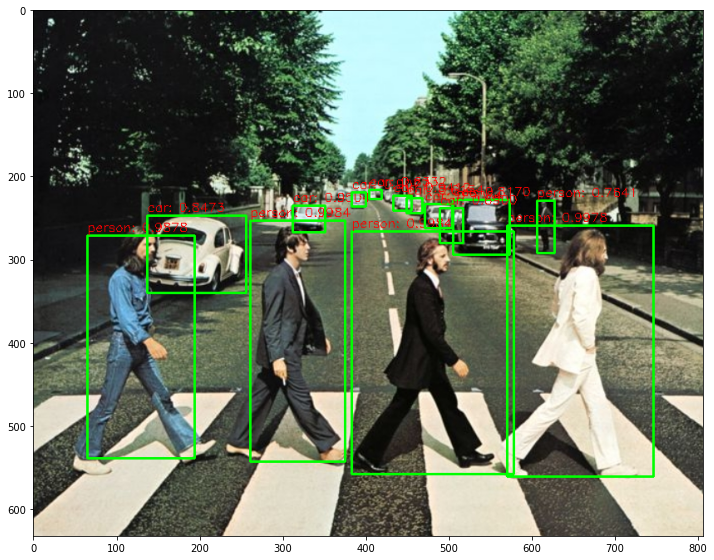

In [12]:
import matplotlib.pyplot as plt

# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)


#### 단일 이미지를 Yolo로 detect하는 get_detected_img() 함수 생성. 

In [16]:
def get_detected_img(cv_net, img_array, conf_threshold, nms_threshold, is_print=True):
    
    # 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
    # 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = img_array.copy()
    
    #전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
    layer_names = cv_net.getLayerNames()
    # opencv DNN이 업그레이드 되면서 cv_net_yolo.getUnconnectedOutLayers()의 반환 결과가 2차원이 아니라 1차원 형태로 layer id가 반환됩니다. 
    # 따라서 아래 코드는 강의 영상의 layers_names[i[0] - 1]에서 layers_names[i - 1] 로 변경합니다. 2022.08.09
    outlayer_names = [layer_names[i - 1] for i in cv_net.getUnconnectedOutLayers()]
    
    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))
    start = time.time()
    # Object Detection 수행하여 결과를 cvOut으로 반환 
    cv_outs = cv_net.forward(outlayer_names)
    layerOutputs = cv_net.forward(outlayer_names)
    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    class_ids = []
    confidences = []
    boxes = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외 
            if confidence > conf_threshold:
                #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
                # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
                # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    
    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img

In [17]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import os

# image 로드 
img = cv2.imread('/content/data/beatles01.jpg')

weights_path = '/content/pretrained/yolov3.weights'
config_path =  '/content/pretrained/yolov3.cfg'

# darknet yolo pretrained 모델 로딩
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)
    


Detection 수행시간: 2.48 초


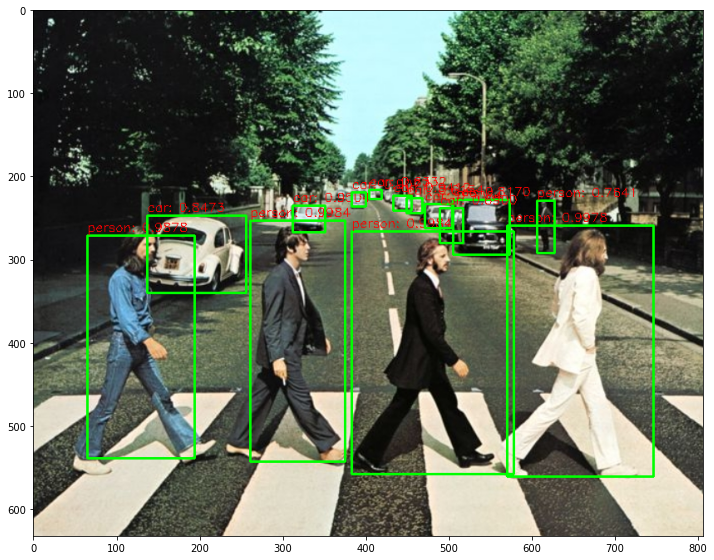

In [18]:
conf_threshold = 0.5
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### tiny Yolo로 Object Detection 수행하기. 

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import os

# image 로드 
img = cv2.imread('/content/data/beatles01.jpg')

weights_path = '/content/pretrained/yolov3-tiny.weights'
config_path =  '/content/pretrained/yolov3-tiny.cfg'

# darknet tiny yolo pretrained 모델 로딩
cv_net_yolo_tiny = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [ ]:
conf_threshold = 0.2
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_yolo_tiny, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)